# Imports

In [2]:
import pandas as pd
import yfinance as yf
from concurrent.futures import ThreadPoolExecutor
import torch
import datetime
from sklearn import metrics
import matplotlib.pyplot as plt
from datasets import load_dataset

# Data loading and cleaning (new dataset)

In [3]:
dataset = load_dataset("edarchimbaud/news-stocks")
dataset.set_format(type='pandas')

df = dataset['train'][:]
df

Generating train split: 100%|██████████| 22025/22025 [00:00<00:00, 127620.56 examples/s]


,symbol,body,publisher,publish_time,title,url,uuid
0,A,Vipshop Holdings Limited VIPS is set to report...,Zacks,2023-05-18 16:14:04+00:00,Vipshop (VIPS) to Post Q1 Earnings: What's in ...,https://finance.yahoo.com/news/vipshop-vips-po...,27293957-38d0-3710-8e36-c33a88428202
1,A,"SANTA CLARA, Calif., May 19, 2023--(BUSINESS W...",Business Wire,2023-05-19 01:25:00+00:00,Agilent to Appeal Patent Office Decision on CR...,https://finance.yahoo.com/news/agilent-appeal-...,5477d2fd-f0e0-3721-aeb5-9e4184af5fc1
2,A,Agilent Technologies A is set to report its se...,Zacks,2023-05-19 15:08:03+00:00,Agilent Technologies (A) to Post Q2 Earnings: ...,https://finance.yahoo.com/news/agilent-technol...,619f9fb9-c102-37fc-8b8c-50c11237b9a7
3,A,"Earnings reports from Zoom Video, Lowe’s, Snow...",Barrons.com,2023-05-21 19:00:00+00:00,"Costco, JPMorgan, Snowflake, Ford, Zoom, and M...",https://finance.yahoo.com/m/5f7a781e-1e0c-30b0...,5f7a781e-1e0c-30b0-a052-1d88fc0ce184
4,A,Agilent Technologies A reported second-quarter...,Zacks,2023-05-24 17:17:00+00:00,"Agilent (A) Q2 Earnings Match Estimates, Reven...",https://finance.yahoo.com/news/agilent-q2-earn...,e9307f15-4308-33d8-a649-57f4df3530b1
...,...,...,...,...,...,...,...
22020,ZTS,When considering what names to put on your wat...,Investor's Business Daily,2023-08-09 18:18:00+00:00,Drugmaker Zoetis Stock Shows Rising Relative S...,https://finance.yahoo.com/m/de58f2c0-d31a-310c...,de58f2c0-d31a-310c-a293-02e6c4206e8c
22021,ZTS,"LINCOLN, Neb., August 09, 2023--(BUSINESS WIRE...",Business Wire,2023-08-09 22:33:00+00:00,Zoetis Welcomes Officials to Open New State-of...,https://finance.yahoo.com/news/zoetis-welcomes...,51662184-e4c7-3e7f-a6a2-7b0666de92cd
22022,ZTS,Investors interested in stocks from the Medica...,Zacks,2023-08-10 15:40:11+00:00,USNA or ZTS: Which Is the Better Value Stock R...,https://finance.yahoo.com/news/usna-zts-better...,14a5e82f-6510-30a5-bbf1-cc4982348c42
22023,ZTS,"In this article, we will be taking a look at t...",Insider Monkey,2023-11-09 08:49:40+00:00,Top 20 Drug Companies in the US by Revenue,https://finance.yahoo.com/news/top-20-drug-com...,636f3ccc-872c-3532-ad4b-675b269c4602


In [4]:
df = df.drop(['publisher', 'url', 'uuid'], axis=1)
df

,symbol,body,publish_time,title
0,A,Vipshop Holdings Limited VIPS is set to report...,2023-05-18 16:14:04+00:00,Vipshop (VIPS) to Post Q1 Earnings: What's in ...
1,A,"SANTA CLARA, Calif., May 19, 2023--(BUSINESS W...",2023-05-19 01:25:00+00:00,Agilent to Appeal Patent Office Decision on CR...
2,A,Agilent Technologies A is set to report its se...,2023-05-19 15:08:03+00:00,Agilent Technologies (A) to Post Q2 Earnings: ...
3,A,"Earnings reports from Zoom Video, Lowe’s, Snow...",2023-05-21 19:00:00+00:00,"Costco, JPMorgan, Snowflake, Ford, Zoom, and M..."
4,A,Agilent Technologies A reported second-quarter...,2023-05-24 17:17:00+00:00,"Agilent (A) Q2 Earnings Match Estimates, Reven..."
...,...,...,...,...
22020,ZTS,When considering what names to put on your wat...,2023-08-09 18:18:00+00:00,Drugmaker Zoetis Stock Shows Rising Relative S...
22021,ZTS,"LINCOLN, Neb., August 09, 2023--(BUSINESS WIRE...",2023-08-09 22:33:00+00:00,Zoetis Welcomes Officials to Open New State-of...
22022,ZTS,Investors interested in stocks from the Medica...,2023-08-10 15:40:11+00:00,USNA or ZTS: Which Is the Better Value Stock R...
22023,ZTS,"In this article, we will be taking a look at t...",2023-11-09 08:49:40+00:00,Top 20 Drug Companies in the US by Revenue


In [5]:
# select stocks
ticker = 'AAPL'

df = df[df['symbol'] == ticker]

df = df.reset_index(drop=True)
df

,symbol,body,publish_time,title
0,AAPL,Apple has stopped some of its employees from u...,2023-05-19 12:08:00+00:00,Apple Bans Some Staff From Using ChatGPT. But ...
1,AAPL,Samsung shelved a review that could have seen ...,2023-05-19 13:19:00+00:00,Google Parent Alphabet Stock Rises. It Got Som...
2,AAPL,Nvidia (NVDA) stock has become a Wall Street d...,2023-05-22 12:26:04+00:00,Nvidia stock is trading on 'heroic' valuations...
3,AAPL,Yahoo Finance markets contributor Remy Blaire ...,2023-05-22 20:15:42+00:00,Apple nears $3 trillion market cap amid Loop C...
4,AAPL,Yahoo Finance Senior Reporter Alexandra Canal ...,2023-05-24 16:12:43+00:00,"Streaming wars evolving between Netflix, Disne..."
...,...,...,...,...
91,AAPL,Epic Games is facing a setback in its legal ba...,2023-08-09 19:55:42+00:00,Supreme Court rules in Apple's favor in Epic G...
92,AAPL,As data has taken a backseat in driving market...,2023-08-10 13:33:34+00:00,Tech: Nvidia earnings 'big catalyst' to watch ...
93,AAPL,Apple (AAPL) shares sink in August amid growth...,2023-08-10 16:23:26+00:00,Apple and Nvidia: How the tech stocks are perf...
94,AAPL,"ChatGPT, OpenAI’s text-generating AI chatbot, ...",2023-11-20 07:00:39+00:00,ChatGPT: Everything you need to know about the...


# Load stock prices

In [6]:
# start date is 7 days before the earliest day from the df
# to make sure at least one trading day before is included
# (there might be weekend days/holidays etc.)

start_date = df['publish_time'].min() - datetime.timedelta(7)
end_date = df['publish_time'].max() + datetime.timedelta(7)

prices = yf.download('AAPL', start_date, end_date)

prices.index = pd.to_datetime(prices.index, format='%Y-%m-%d', utc=True)
prices

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-12 00:00:00+00:00,173.619995,174.059998,171.000000,172.570007,171.891190,45497800
2023-05-15 00:00:00+00:00,173.160004,173.210007,171.470001,172.070007,171.393173,37266700
2023-05-16 00:00:00+00:00,171.990005,173.139999,171.800003,172.070007,171.393173,42110300
2023-05-17 00:00:00+00:00,171.710007,172.929993,170.419998,172.690002,172.010727,57951600
2023-05-18 00:00:00+00:00,173.000000,175.240005,172.580002,175.050003,174.361435,65496700
...,...,...,...,...,...,...
2023-11-20 00:00:00+00:00,189.889999,191.910004,189.880005,191.449997,191.206009,46505100
2023-11-21 00:00:00+00:00,191.410004,191.520004,189.740005,190.639999,190.397049,38134500
2023-11-22 00:00:00+00:00,191.490005,192.929993,190.830002,191.309998,191.066193,39617700


# News summarization

In [7]:
from transformers import PegasusTokenizer, PegasusForConditionalGeneration, TFPegasusForConditionalGeneration

model_name = "human-centered-summarization/financial-summarization-pegasus"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at human-centered-summarization/financial-summarization-pegasus and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
def get_summary(text):

  text = text[:512]

  input_ids = tokenizer(text, return_tensors="pt").input_ids

  # Generate the output (Here, we use beam search but you can also use any other strategy you like)
  output = model.generate(
      input_ids,
      max_length=32,
      num_beams=5,
      early_stopping=True
  )

  return tokenizer.decode(output[0], skip_special_tokens=True)

df['summary'] = df['body'].apply(get_summary)
df

,symbol,body,publish_time,title,summary
0,AAPL,Apple has stopped some of its employees from u...,2023-05-19 12:08:00+00:00,Apple Bans Some Staff From Using ChatGPT. But ...,Some employees have been banned from using Cha...
1,AAPL,Samsung shelved a review that could have seen ...,2023-05-19 13:19:00+00:00,Google Parent Alphabet Stock Rises. It Got Som...,Google’s search engine has been removed from S...
2,AAPL,Nvidia (NVDA) stock has become a Wall Street d...,2023-05-22 12:26:04+00:00,Nvidia stock is trading on 'heroic' valuations...,Shares of chip giant are up 115% in 2020 vs. N...
3,AAPL,Yahoo Finance markets contributor Remy Blaire ...,2023-05-22 20:15:42+00:00,Apple nears $3 trillion market cap amid Loop C...,Loop Capital cuts its price target on Apple to...
4,AAPL,Yahoo Finance Senior Reporter Alexandra Canal ...,2023-05-24 16:12:43+00:00,"Streaming wars evolving between Netflix, Disne...","With advertising taking center stage, could we..."
...,...,...,...,...,...
91,AAPL,Epic Games is facing a setback in its legal ba...,2023-08-09 19:55:42+00:00,Supreme Court rules in Apple's favor in Epic G...,"Apple can keep its app store payment rules, Su..."
92,AAPL,As data has taken a backseat in driving market...,2023-08-10 13:33:34+00:00,Tech: Nvidia earnings 'big catalyst' to watch ...,"Nvidia is key to watch for earnings, Lerner says."
93,AAPL,Apple (AAPL) shares sink in August amid growth...,2023-08-10 16:23:26+00:00,Apple and Nvidia: How the tech stocks are perf...,"Apple, Nvidia and more in the news this month."
94,AAPL,"ChatGPT, OpenAI’s text-generating AI chatbot, ...",2023-11-20 07:00:39+00:00,ChatGPT: Everything you need to know about the...,OpenAI’s ChatGPT is used by more than 92% of F...


# Sentiment Analysis

In [9]:
from scipy.special import softmax
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

def sentiment_score(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    scores = outputs.logits[0].detach().numpy()
    scores = softmax(scores)
    return scores


def fetch_sentiments_for_dataframe(df, model, tokenizer):
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = [executor.submit(sentiment_score, row['title']) for index, row in df.iterrows()]
        sentiments = [future.result() for future in futures]
    return sentiments


df['sentiment_scores'] = fetch_sentiments_for_dataframe(df, model, tokenizer)
df

,symbol,body,publish_time,title,summary,sentiment_scores
0,AAPL,Apple has stopped some of its employees from u...,2023-05-19 12:08:00+00:00,Apple Bans Some Staff From Using ChatGPT. But ...,Some employees have been banned from using Cha...,"[0.014020246, 0.76393926, 0.22204055]"
1,AAPL,Samsung shelved a review that could have seen ...,2023-05-19 13:19:00+00:00,Google Parent Alphabet Stock Rises. It Got Som...,Google’s search engine has been removed from S...,"[0.61172295, 0.11752826, 0.27074876]"
2,AAPL,Nvidia (NVDA) stock has become a Wall Street d...,2023-05-22 12:26:04+00:00,Nvidia stock is trading on 'heroic' valuations...,Shares of chip giant are up 115% in 2020 vs. N...,"[0.05900104, 0.086460516, 0.8545385]"
3,AAPL,Yahoo Finance markets contributor Remy Blaire ...,2023-05-22 20:15:42+00:00,Apple nears $3 trillion market cap amid Loop C...,Loop Capital cuts its price target on Apple to...,"[0.025485024, 0.9548232, 0.019691793]"
4,AAPL,Yahoo Finance Senior Reporter Alexandra Canal ...,2023-05-24 16:12:43+00:00,"Streaming wars evolving between Netflix, Disne...","With advertising taking center stage, could we...","[0.031807497, 0.07774747, 0.890445]"
...,...,...,...,...,...,...
91,AAPL,Epic Games is facing a setback in its legal ba...,2023-08-09 19:55:42+00:00,Supreme Court rules in Apple's favor in Epic G...,"Apple can keep its app store payment rules, Su...","[0.13988023, 0.21028851, 0.64983124]"
92,AAPL,As data has taken a backseat in driving market...,2023-08-10 13:33:34+00:00,Tech: Nvidia earnings 'big catalyst' to watch ...,"Nvidia is key to watch for earnings, Lerner says.","[0.2441683, 0.013330111, 0.7425016]"
93,AAPL,Apple (AAPL) shares sink in August amid growth...,2023-08-10 16:23:26+00:00,Apple and Nvidia: How the tech stocks are perf...,"Apple, Nvidia and more in the news this month.","[0.079906516, 0.11852221, 0.8015713]"
94,AAPL,"ChatGPT, OpenAI’s text-generating AI chatbot, ...",2023-11-20 07:00:39+00:00,ChatGPT: Everything you need to know about the...,OpenAI’s ChatGPT is used by more than 92% of F...,"[0.040022917, 0.018011672, 0.9419654]"


# Calculate trends and predicted trends

In [10]:
def trend(date):
  # trends are calculated using the close price from the previous trading day
  # and the open price of the next trading day to include the moment when the
  # news was made public (during or outside the trading hours)
  prev_date = prices[prices.index < date].index.max()
  prev_date_index = prices.index.get_loc(prev_date.strftime('%Y-%m-%d'))

  if date.strftime('%Y-%m-%d') == prev_date.strftime('%Y-%m-%d'):
    prev_date_index -= 1

  next_date = prices[prices.index > date].index.min()
  next_date_index = prices.index.get_loc(next_date.strftime('%Y-%m-%d'))
  ret = ((prices['Open'][next_date_index] - prices['Close'][prev_date_index]) / prices['Close'][prev_date_index]) * 100

  return_threshold = 1.0 # (1%)
  if ret >= return_threshold:
    return 'increase'
  elif ret <= -return_threshold:
    return 'decrease'
  else:
    return 'stable'


df['trend'] = df['publish_time'].apply(trend)



def predicted_trend(sentiment_score):
  sentiment_threshold = 0.7 # (70%)
  if sentiment_score[0] >= sentiment_threshold:
    return 'increase'
  elif sentiment_score[1] >= sentiment_threshold:
    return 'decrease'
  else:
    return 'stable'


df['predicted_trend'] = df['sentiment_scores'].apply(predicted_trend)
df

,symbol,body,publish_time,title,summary,sentiment_scores,trend,predicted_trend
0,AAPL,Apple has stopped some of its employees from u...,2023-05-19 12:08:00+00:00,Apple Bans Some Staff From Using ChatGPT. But ...,Some employees have been banned from using Cha...,"[0.014020246, 0.76393926, 0.22204055]",stable,decrease
1,AAPL,Samsung shelved a review that could have seen ...,2023-05-19 13:19:00+00:00,Google Parent Alphabet Stock Rises. It Got Som...,Google’s search engine has been removed from S...,"[0.61172295, 0.11752826, 0.27074876]",stable,stable
2,AAPL,Nvidia (NVDA) stock has become a Wall Street d...,2023-05-22 12:26:04+00:00,Nvidia stock is trading on 'heroic' valuations...,Shares of chip giant are up 115% in 2020 vs. N...,"[0.05900104, 0.086460516, 0.8545385]",decrease,stable
3,AAPL,Yahoo Finance markets contributor Remy Blaire ...,2023-05-22 20:15:42+00:00,Apple nears $3 trillion market cap amid Loop C...,Loop Capital cuts its price target on Apple to...,"[0.025485024, 0.9548232, 0.019691793]",decrease,decrease
4,AAPL,Yahoo Finance Senior Reporter Alexandra Canal ...,2023-05-24 16:12:43+00:00,"Streaming wars evolving between Netflix, Disne...","With advertising taking center stage, could we...","[0.031807497, 0.07774747, 0.890445]",stable,stable
...,...,...,...,...,...,...,...,...
91,AAPL,Epic Games is facing a setback in its legal ba...,2023-08-09 19:55:42+00:00,Supreme Court rules in Apple's favor in Epic G...,"Apple can keep its app store payment rules, Su...","[0.13988023, 0.21028851, 0.64983124]",stable,stable
92,AAPL,As data has taken a backseat in driving market...,2023-08-10 13:33:34+00:00,Tech: Nvidia earnings 'big catalyst' to watch ...,"Nvidia is key to watch for earnings, Lerner says.","[0.2441683, 0.013330111, 0.7425016]",stable,stable
93,AAPL,Apple (AAPL) shares sink in August amid growth...,2023-08-10 16:23:26+00:00,Apple and Nvidia: How the tech stocks are perf...,"Apple, Nvidia and more in the news this month.","[0.079906516, 0.11852221, 0.8015713]",stable,stable
94,AAPL,"ChatGPT, OpenAI’s text-generating AI chatbot, ...",2023-11-20 07:00:39+00:00,ChatGPT: Everything you need to know about the...,OpenAI’s ChatGPT is used by more than 92% of F...,"[0.040022917, 0.018011672, 0.9419654]",stable,stable


# Results

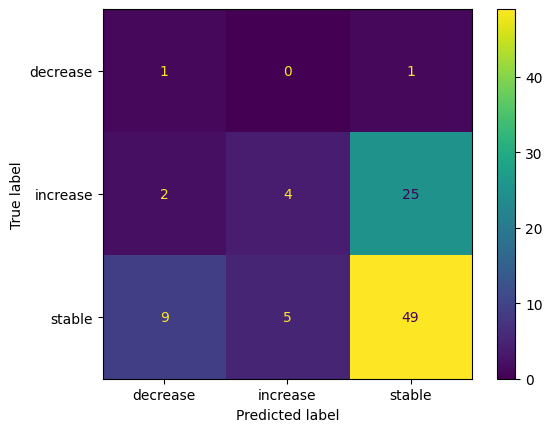

In [11]:
confusion_matrix = metrics.confusion_matrix(df['trend'], df['predicted_trend'])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['decrease', 'increase', 'stable'])

cm_display.plot()
plt.show()

# Ranking intragroup articles

### Pass articles through BERT

In [60]:
from transformers import BertTokenizer, BertModel

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

group = df[['symbol', 'body', 'title', 'summary']]

# tokenize and encode the summaries
def tokenize(text, tokenizer):
  return tokenizer.encode_plus(
    text, # article summary
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    max_length=512,
    truncation=True,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt'
  )

def encode_bert(encoded, model):
    with torch.no_grad():
        outputs = model(**encoded)
        cls = outputs.last_hidden_state[:, 0, :] # extract the [CLS] token embedding
    return cls

# encode the summaries
group['classification'] = group['summary'].apply(tokenize, tokenizer=bert_tokenizer).apply(encode_bert, model=bert_model)

group

/var/folders/mq/brmwp94d7nl6sfg3kspvtftw0000gn/T/ipykernel_32815/3528776777.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group.loc[:, 'classification'] = group['summary'].apply(tokenize, tokenizer=bert_tokenizer).apply(encode_bert, model=bert_model)


,symbol,body,title,summary,classification
0,AAPL,Apple has stopped some of its employees from u...,Apple Bans Some Staff From Using ChatGPT. But ...,Some employees have been banned from using Cha...,"[[tensor(-0.1968), tensor(-0.1578), tensor(-0...."
1,AAPL,Samsung shelved a review that could have seen ...,Google Parent Alphabet Stock Rises. It Got Som...,Google’s search engine has been removed from S...,"[[tensor(-0.4161), tensor(0.1011), tensor(-0.3..."
2,AAPL,Nvidia (NVDA) stock has become a Wall Street d...,Nvidia stock is trading on 'heroic' valuations...,Shares of chip giant are up 115% in 2020 vs. N...,"[[tensor(-0.4229), tensor(-0.1169), tensor(0.4..."
3,AAPL,Yahoo Finance markets contributor Remy Blaire ...,Apple nears $3 trillion market cap amid Loop C...,Loop Capital cuts its price target on Apple to...,"[[tensor(-0.4997), tensor(-0.1480), tensor(-0...."
4,AAPL,Yahoo Finance Senior Reporter Alexandra Canal ...,"Streaming wars evolving between Netflix, Disne...","With advertising taking center stage, could we...","[[tensor(0.0311), tensor(-0.2226), tensor(-0.0..."
...,...,...,...,...,...
91,AAPL,Epic Games is facing a setback in its legal ba...,Supreme Court rules in Apple's favor in Epic G...,"Apple can keep its app store payment rules, Su...","[[tensor(-0.0524), tensor(0.1057), tensor(0.18..."
92,AAPL,As data has taken a backseat in driving market...,Tech: Nvidia earnings 'big catalyst' to watch ...,"Nvidia is key to watch for earnings, Lerner says.","[[tensor(0.0126), tensor(0.1793), tensor(0.070..."
93,AAPL,Apple (AAPL) shares sink in August amid growth...,Apple and Nvidia: How the tech stocks are perf...,"Apple, Nvidia and more in the news this month.","[[tensor(-0.2064), tensor(-0.1885), tensor(0.1..."
94,AAPL,"ChatGPT, OpenAI’s text-generating AI chatbot, ...",ChatGPT: Everything you need to know about the...,OpenAI’s ChatGPT is used by more than 92% of F...,"[[tensor(-0.6488), tensor(0.0396), tensor(0.07..."


### Use CLS tokens to calculate importance score

Using a simple neural network with a sigmoid function, we calculate the importance scores from the [CLS] embeddings.

Source: https://aclanthology.org/D19-5106.pdf

In [61]:
import torch.nn as nn

# fixed seed for reproducibility
torch.manual_seed(1234)

# define the importance scorer
class ImportanceScorer(nn.Module):
    def __init__(self, hidden_size):
        super(ImportanceScorer, self).__init__()
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.linear(x))

scorer = ImportanceScorer(bert_model.config.hidden_size)
cls_embeddings = torch.cat(group['classification'].to_list(), dim=0)

# calculate the importance scores
with torch.no_grad():
    scores = scorer(cls_embeddings).squeeze().numpy()
group['importance'] = scores

group.sort_values(by='importance', ascending=False, inplace=False)

/var/folders/mq/brmwp94d7nl6sfg3kspvtftw0000gn/T/ipykernel_32815/579703942.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['importance'] = scores


,symbol,body,title,summary,classification,importance
32,AAPL,Apple unveiling its Vision Pro mixed reality h...,"Apple's headset revealed, SEC sues Binance, oi...",Saudi Arabia pledges to cut production by one ...,"[[tensor(-0.7658), tensor(0.0064), tensor(-0.1...",0.690669
13,AAPL,"The stock market is on a growth path, with the...","Why Amazon, PayPal, and Apple Are No-Brainer B...",North America segment returned to profitabilit...,"[[tensor(-0.8590), tensor(-0.3518), tensor(-0....",0.685167
37,AAPL,"When it comes to market sectors, last year’s l...",Stock market winners in 2023 are last year's l...,"Technology, Communication Services top S&P 500...","[[tensor(-0.8218), tensor(-0.1342), tensor(0.2...",0.678890
75,AAPL,The Dow Jones and Russell 2000 rallied Thursda...,Dow Jones Rallies As Fed Rate Hike Odds Rise W...,"Nike earnings mixed, Apple given a high target.","[[tensor(-0.3771), tensor(-0.4664), tensor(0.0...",0.674630
28,AAPL,"Apple's WWDC 2023 is set to take place Monday,...","Apple's WWDC, GameStop earnings, econ. data: W...",Tech giant is expected to unveil a new mixed r...,"[[tensor(-0.7534), tensor(-0.4048), tensor(0.4...",0.668245
...,...,...,...,...,...,...
20,AAPL,"TAIPEI, May 31 (Reuters) - Apple Inc supplier ...","Foxconn sees AI driving strong server demand, ...",Demand for servers will be a bright spot for t...,"[[tensor(0.0263), tensor(0.1506), tensor(0.396...",0.523892
94,AAPL,"ChatGPT, OpenAI’s text-generating AI chatbot, ...",ChatGPT: Everything you need to know about the...,OpenAI’s ChatGPT is used by more than 92% of F...,"[[tensor(-0.6488), tensor(0.0396), tensor(0.07...",0.519782
95,AAPL,(Bloomberg) -- Epic Games Inc. Chief Executive...,Epic Games’ Sweeney Takes Aim at Android’s ‘Fa...,Epic CEO says Google’s operating system is a ‘...,"[[tensor(-0.0119), tensor(0.3178), tensor(0.02...",0.507334
22,AAPL,"For decades, ever-tinier semiconductors have a...",The big question of how small chips can get,Slower-than-expected growth in memory chips co...,"[[tensor(-0.3407), tensor(-0.1874), tensor(-0....",0.507140
